In [15]:
import os
import json
import shap
import graphviz
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import Image
from scipy.stats import spearmanr, pearsonr
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error
from consts import DATA_CLEAN_ACTION_PATH_X, DATA_CLEAN_ACTION_PATH_Y, DATA_GAME_REVIEWS_PATH, reaction_time_bins, PROBA2GO_DICT

/anaconda/envs/final_project_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the data

In [16]:
X_df = pd.read_csv(DATA_CLEAN_ACTION_PATH_X)
y_df = pd.read_csv(DATA_CLEAN_ACTION_PATH_Y)
X_df['user_id'] = X_df['user_id'].apply(lambda x: 'X_' + str(x))
y_df['user_id'] = y_df['user_id'].apply(lambda x: 'y_' + str(x))
labels = range(len(reaction_time_bins) + 1)
bin_edges = [-1] + [b[0] for b in reaction_time_bins] + [reaction_time_bins[-1][1]]
bin_labels = ["-1-0"] + [f"{b[0]}-{b[1]}" if b[1] != np.inf else f"{b[0]}+" for b in reaction_time_bins]

### Adding Reviews Features

In [20]:
hotel_dfs = dict()
with open("data/baseline_proba2go.txt", 'r') as file:
    probs_dict = json.load(file)
def load_hotel_df(hotel_id):
    if hotel_id not in hotel_dfs:
        hotel_dfs[hotel_id] = pd.read_csv(os.path.join(DATA_GAME_REVIEWS_PATH, f'{hotel_id}.csv'), names=['reviewId', 'hotelId', 'positive', 'negative', 'score'])

    return hotel_dfs[hotel_id]

def get_review(row):
    hotel_id = row['hotelId']
    review_id = row['reviewId']
    hotel_df = load_hotel_df(hotel_id)
    review_row = hotel_df.loc[hotel_df['reviewId'] == review_id]
    positive_review = review_row['positive'].iloc[0]
    negative_review = review_row['negative'].iloc[0]
    review_score = review_row['score'].iloc[0]
    return pd.Series([positive_review, negative_review, review_score])

def add_review_prob(row):
    review_id = row['reviewId']
    return probs_dict[str(review_id)]

### Adding Mistakes Features

In [21]:
def add_mistakes_columns(df):
    # Calculate the cumulative sum of mistakes, then shift within each group so the calculation will be correct to the start of the round
    df['mistakes_cumulative'] = df.groupby(['user_id', 'gameId'])['didWin'].transform(lambda x: (~x).cumsum())  
    df['current_game_mistakes_amount'] = df.groupby(['user_id', 'gameId'])['mistakes_cumulative'].shift(fill_value=0)  
    
    # Calculate cumulative mistakes across all games for each user, then shift  
    df['total_mistakes_cumulative'] = df.groupby(['user_id'])['didWin'].transform(lambda x: (~x).cumsum())  
    df['total_games_mistakes_amount'] = df.groupby(['user_id'])['total_mistakes_cumulative'].shift(fill_value=0)  
    
    # For percentage calculations, adjust for the shift by avoiding division by zero  
    df['rounds_so_far'] = df.groupby(['user_id', 'gameId']).cumcount()  
    df['total_rounds_so_far'] = df.groupby(['user_id']).cumcount() 
    df['current_game_mistakes_percentage'] = df['current_game_mistakes_amount'] / df['rounds_so_far'].replace(0, pd.NA)  
    df['total_games_mistakes_percentage'] = df['total_games_mistakes_amount'] / df['total_rounds_so_far'].replace(0, pd.NA)  
    
    # Fill NaN values in the percentage columns  
    df.fillna({'current_game_mistakes_percentage': 0, 'total_games_mistakes_percentage': 0}, inplace=True)  
    df.drop(['mistakes_cumulative', 'total_mistakes_cumulative', 'rounds_so_far', 'total_rounds_so_far'], axis=1, inplace=True)
    return df

In [19]:
def lost_cause(row, strategy_threshold_dict):
    if 10 - strategy_threshold_dict[row['strategy_id']] < row['current_game_mistakes_amount']:
        return 1 
    else:
        return 0

### Extracting Players Strategies

In [22]:
from Simulation.dm_strategies import BOT_ACTION, REVIEWS
def history_and_review_quality(history_window, quality_threshold, information):      
    if len(information["previous_rounds"]) == 0 \
            or history_window == 0 \
            or np.min(np.array([((r[BOT_ACTION] >= 8 and r[REVIEWS] >= 8)
                                    or (r[BOT_ACTION] <= 8 and r[REVIEWS] < 8)) for r in
                                information["previous_rounds"][
                                -history_window:]])) == 1:          
        if information["bot_message"] >= quality_threshold: 
            return 1
        else:
            return 0
    else:
        return 0


def LLM_based(information):
    proba2go = {int(k): v for k, v in PROBA2GO_DICT.items()}
    review_llm_score = proba2go[information["review_id"]]
    return int(np.random.rand() <= review_llm_score)


def create_information(group):
    group['information'] = [
        [(hotel_score, review_score) for hotel_score, review_score in zip(group['hotelScore'][:i], group['review_score'][:i])] 
        for i in range(len(group))
    ]
    return group

def calculate_played_oracle(group):
    did_win = group['didWin'].values
    played_oracle = [
        np.array_equal(did_win[max(0, i - 2): min(i + 1, len(group))], [True, True, True]) or
        np.array_equal(did_win[max(0, i - 1): min(i + 2, len(group))], [True, True, True]) # or
        # np.array_equal(did_win[i: min(i + 3, len(group))], [True, True, True])
        for i in range(len(did_win))
    ]
    group['played_oracle'] = played_oracle
    return group


def calculate_played_random(group):
    did_win = group['didWin'].values
    played_random = [
        0.4 <= np.array(did_win[0: i + 1]).mean() <= 0.6
        for i in range(len(did_win))
    ]
    group['played_random'] = played_random
    return group


def calculate_trustful_and_llm(row, user_properties):
    user_id = row['user_id']
    review_id = row['reviewId']
    bot_message = row['review_score']
    history_window = user_properties[user_id]['history_window']
    quality_threshold = user_properties[user_id]['quality_threshold']
    information = {'previous_rounds': row['information'], 'bot_message': bot_message, 'review_id': review_id}
    
    trustful_decision = history_and_review_quality(history_window, quality_threshold, information)
    llm_decision = LLM_based(information)
    
    return pd.Series([trustful_decision, llm_decision])

### Adding All features

In [23]:
def pre_process(actions_df, bot_thresholds):
    actions_df['reaction_time_bins'] = pd.cut(actions_df['reaction_time'], bins=bin_edges, include_lowest=True)
    actions_df['last_reaction_time_bins'] = pd.cut(actions_df['last_reaction_time'], bins=bin_edges, include_lowest=True)
    actions_df['last_reaction_time_bins_categories'] = actions_df['last_reaction_time_bins'].apply(lambda x: (x.left))
    actions_df['reaction_time_bins_categories'] = actions_df['reaction_time_bins'].apply(lambda x: (x.left))
    actions_df[['positive_review', 'negative_review', 'review_score']] = actions_df.apply(get_review, axis=1)
    actions_df['positive_review'] = actions_df['positive_review'].fillna('')
    actions_df['negative_review'] = actions_df['negative_review'].fillna('')
    actions_df['review_length'] = actions_df['positive_review'].str.len() + actions_df['negative_review'].str.len()
    actions_df['positive_review_proportion'] = actions_df.apply(lambda row: len(row['positive_review']) / row['review_length'] if row['review_length'] != 0 else 0, axis=1)
    actions_df['positive_negative_proportion'] = actions_df.apply(lambda row: len(row['positive_review']) / len(row['negative_review']) if row['negative_review'] != '' else 0, axis=1)
    actions_df['negative_positive_proportion'] = actions_df.apply(lambda row: len(row['negative_review']) / len(row['positive_review']) if row['positive_review'] != '' else 0, axis=1)
    actions_df['negative_review_proportion'] = actions_df.apply(lambda row: len(row['negative_review']) / row['review_length'] if row['review_length'] != 0 else 0, axis=1)
    actions_df = add_mistakes_columns(actions_df)
    actions_df['user_earned_more'] = actions_df['user_points'] >= actions_df['bot_points']
    actions_df['bot_earned_more'] = actions_df['user_points'] < actions_df['bot_points']
    actions_df['review_prob'] = actions_df.apply(add_review_prob, axis=1)
    actions_df['lost_cause'] = actions_df.apply(lost_cause, args=(bot_thresholds,), axis=1)

    user_properties = {
    user_id: {
        'history_window': np.random.negative_binomial(2, 1 / 2) + np.random.randint(0, 2),
        'quality_threshold': np.random.normal(8, 0.5),
        'random_noise': np.random.normal(0, 0.1)
    } 
    for user_id in actions_df['user_id'].unique()
    }

    strategies_df = actions_df[['user_id', 'gameId', 'reviewId', 'strategy_id', 'hotelScore', 'review_score', 'didWin', 'didGo']] \
        .groupby(by=['user_id', 'gameId']).apply(create_information).reset_index(drop=True)
    strategies_df = strategies_df.groupby(by=['user_id', 'gameId']).apply(calculate_played_oracle).reset_index(drop=True)
    strategies_df[['trustful_decision', 'llm_decision']] = strategies_df.apply(lambda row: calculate_trustful_and_llm(row, user_properties), axis=1)
    strategies_df['played_trustful'] = strategies_df['trustful_decision'] == strategies_df['didGo']
    strategies_df['played_llm'] = strategies_df['llm_decision'] == strategies_df['didGo']
    strategies_df['played_random'] = False
    mask = (strategies_df['played_oracle'] == 0) & (strategies_df['trustful_decision'] == 0) & (strategies_df['llm_decision'] == 0)
    random_options = strategies_df[mask].index
    played_random_results = strategies_df.loc[random_options].groupby(['user_id', 'gameId']).apply(calculate_played_random).reset_index(drop=True)
    strategies_df.loc[random_options, 'played_random'] = played_random_results['played_random'].values
    strategies_df['played_oracle']  = strategies_df['played_oracle'].astype(int)
    strategies_df['played_random']  = strategies_df['played_random'].astype(int)
    actions_df = actions_df.merge(strategies_df)

    return actions_df

In [25]:
bot_thresholds_X = {3: 10, 0: 7, 2: 9, 5: 8, 59: 8, 19: 9}
bot_thresholds_Y = {132: 10, 23: 9, 107: 9, 43: 9, 17: 9, 93: 9}

train_df = pre_process(X_df, bot_thresholds_X)
test_df = pre_process(y_df, bot_thresholds_Y)

### EDA

In [30]:
all_features = ['gameId', 'roundNum', 'user_points', 'bot_points', 'last_didGo_True', 'last_last_didGo_True', 'last_didWin_True', 'last_last_didWin_True', 'review_prob',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount', 'review_length',
                'positive_review_proportion','negative_review_proportion','positive_negative_proportion','negative_positive_proportion','user_earned_more', 'bot_earned_more',
                 'last_reaction_time', 'last_reaction_time_bins_categories', 'played_trustful', 'played_llm', 'played_random', 'played_oracle', 'lost_cause']

regression_label_column = 'reaction_time'
classification_label_column = 'reaction_time_bins_categories'

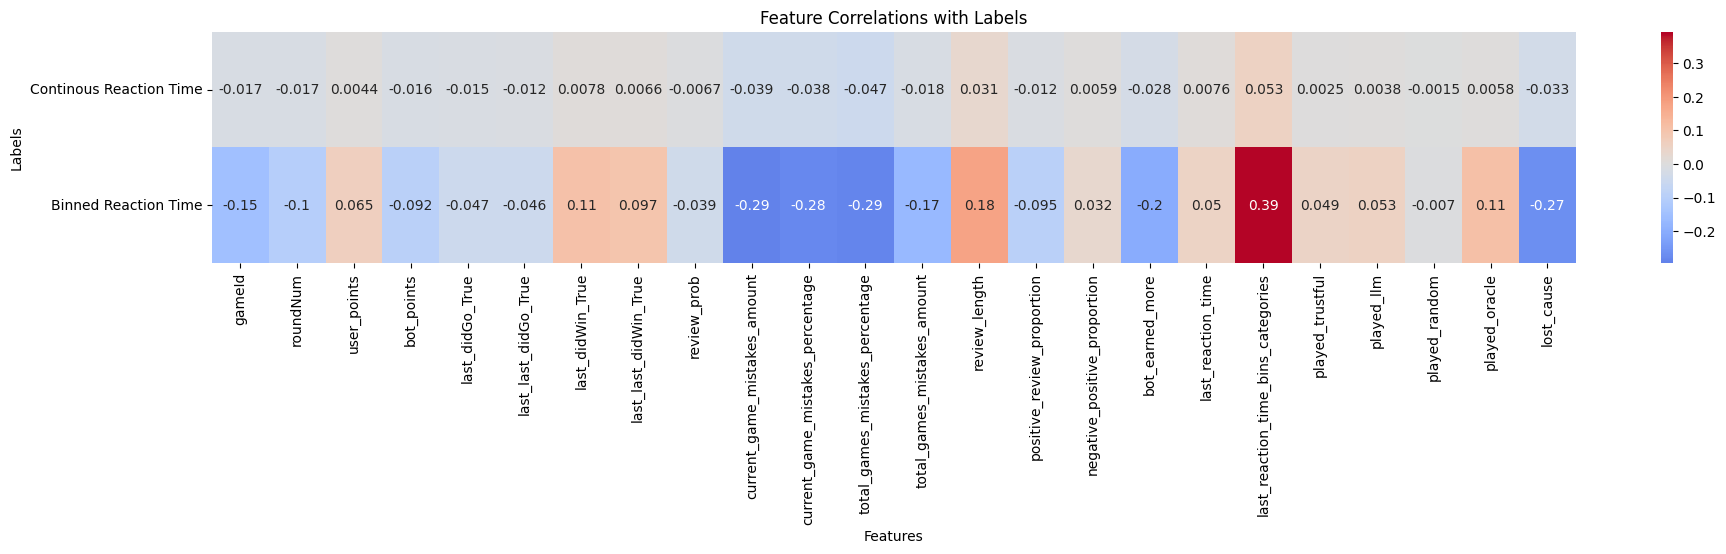

In [31]:
clean_features = ['gameId', 'roundNum', 'user_points', 'bot_points', 'last_didGo_True', 'last_last_didGo_True', 'last_didWin_True', 'last_last_didWin_True', 'review_prob',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount', 'review_length',
                'positive_review_proportion','negative_positive_proportion', 'bot_earned_more',
                 'last_reaction_time', 'last_reaction_time_bins_categories', 'played_trustful', 'played_llm', 'played_random', 'played_oracle', 'lost_cause']
regression_correlations = train_df[clean_features].apply(lambda x: x.corr(train_df[regression_label_column]))
classification_correlations = train_df[clean_features].apply(lambda x: x.corr(train_df[classification_label_column]))
correlations_df = pd.DataFrame({
    'Continous Reaction Time': regression_correlations,
    'Binned Reaction Time': classification_correlations
}).T

plt.figure(figsize=(22, 3))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations with Labels')
plt.xlabel('Features')
plt.ylabel('Labels')
plt.show()

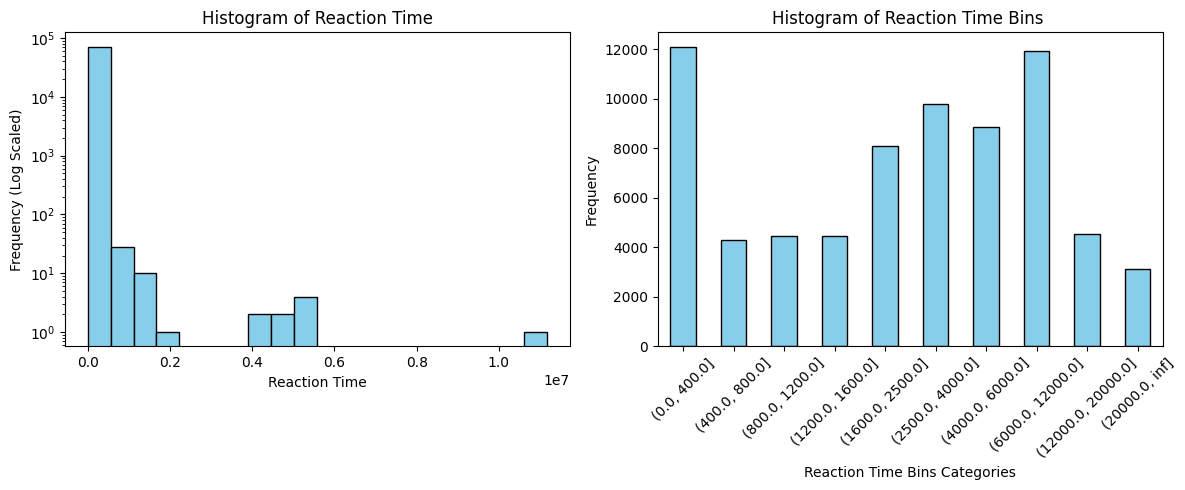

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for the regression label (reaction_time)
axes[0].hist(train_df['reaction_time'], bins=20, color='skyblue', edgecolor='black', log=True)
axes[0].set_title('Histogram of Reaction Time')
axes[0].set_xlabel('Reaction Time')
axes[0].set_ylabel('Frequency (Log Scaled)')

# Plot histogram for the classification label (reaction_time_bins_categories)
bins_count = train_df['reaction_time_bins'].value_counts()
bins_count = bins_count[bins_count > 0]
bins_count.sort_index().plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Histogram of Reaction Time Bins ')
axes[1].set_xlabel('Reaction Time Bins Categories')
axes[1].set_ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

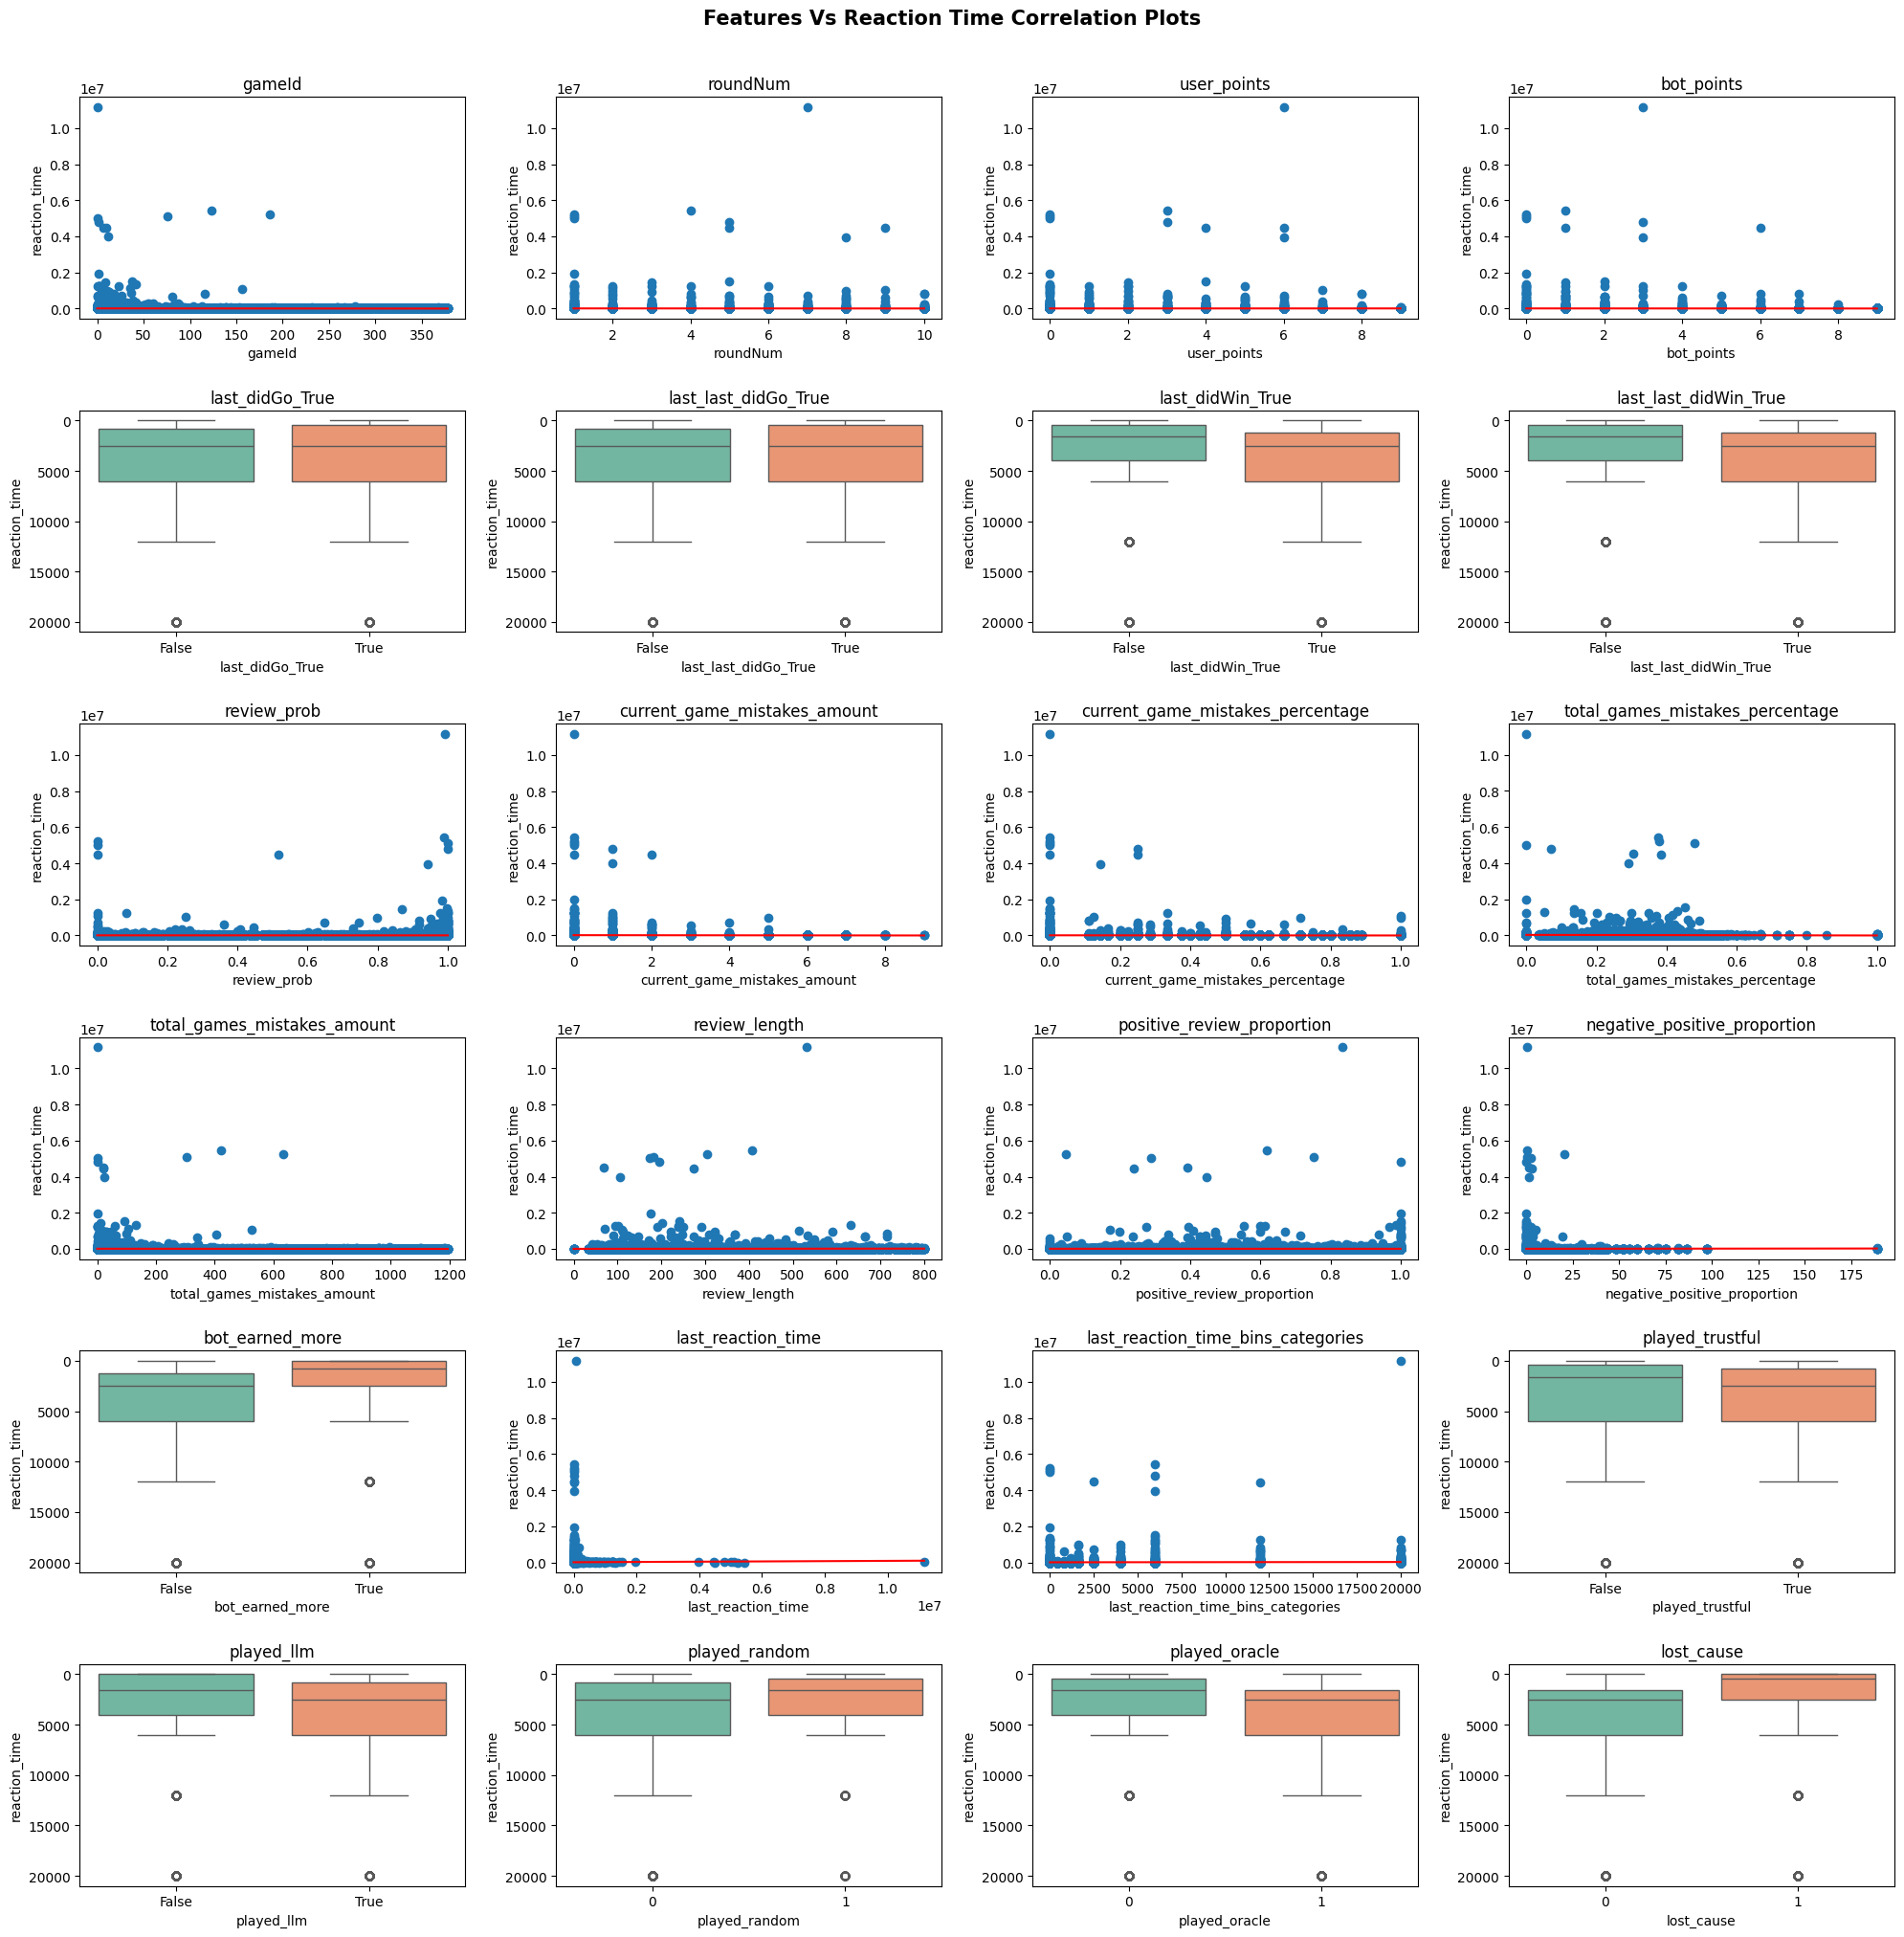

In [32]:
import warnings
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(6, 4, figsize=(20, 20))
axes = axes.flatten()

# Plot correlation plots
for i, feature in enumerate(clean_features):
    if train_df[feature].nunique() > 9:
        coefficients = np.polyfit(train_df[feature], train_df[regression_label_column], 1)
        polynomial = np.poly1d(coefficients)
        x_values = np.linspace(min(train_df[feature]), max(train_df[feature]), 100)
        y_values = polynomial(x_values)
        axes[i].plot(x_values, y_values, color='red', label='Regression Line')
        axes[i].scatter(train_df[feature], train_df[regression_label_column], label='Data Points')
        
    else:
        sns.boxplot(x=train_df[feature].astype(str), y=train_df[classification_label_column], ax=axes[i], palette="Set2")
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(regression_label_column)

# axes[-1].remove()
plt.suptitle('Features Vs Reaction Time Correlation Plots', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

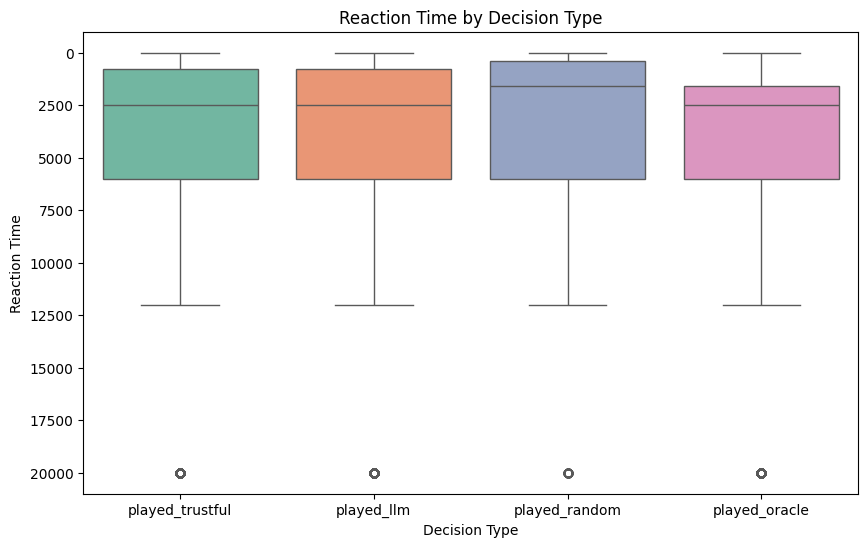

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


copy_train_df = train_df.copy()
copy_train_df['played_trustful'] = copy_train_df['trustful_decision'].astype(bool)
copy_train_df['played_llm'] = copy_train_df['llm_decision'].astype(bool)
copy_train_df['played_random'] = copy_train_df['played_random'].astype(bool)
copy_train_df['played_oracle'] = copy_train_df['played_oracle'].astype(bool)

# Create a melted DataFrame for easier plotting
melted_df = copy_train_df.melt(
    id_vars=['reaction_time_bins_categories'],
    value_vars=['played_trustful', 'played_llm', 'played_random', 'played_oracle'],
    var_name='decision_type',
    value_name='played'
)

# Filter only true values
melted_df = melted_df[melted_df['played']]

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='decision_type', y=classification_label_column, data=melted_df, palette='Set2')
plt.title('Reaction Time by Decision Type')
plt.xlabel('Decision Type')
plt.ylabel('Reaction Time')
plt.show()


### Regression Modeling (Continous Representation)

In [21]:
X_train, y_train =  train_df[all_features], train_df[regression_label_column]
X_test, y_test = test_df[all_features], test_df[regression_label_column]

In [22]:
model = RandomForestRegressor(min_samples_leaf=50, max_depth=100)
model.fit(X_train[all_features], y_train)
y_pred = model.predict(X_test[all_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(rmse)

359.93888736525605


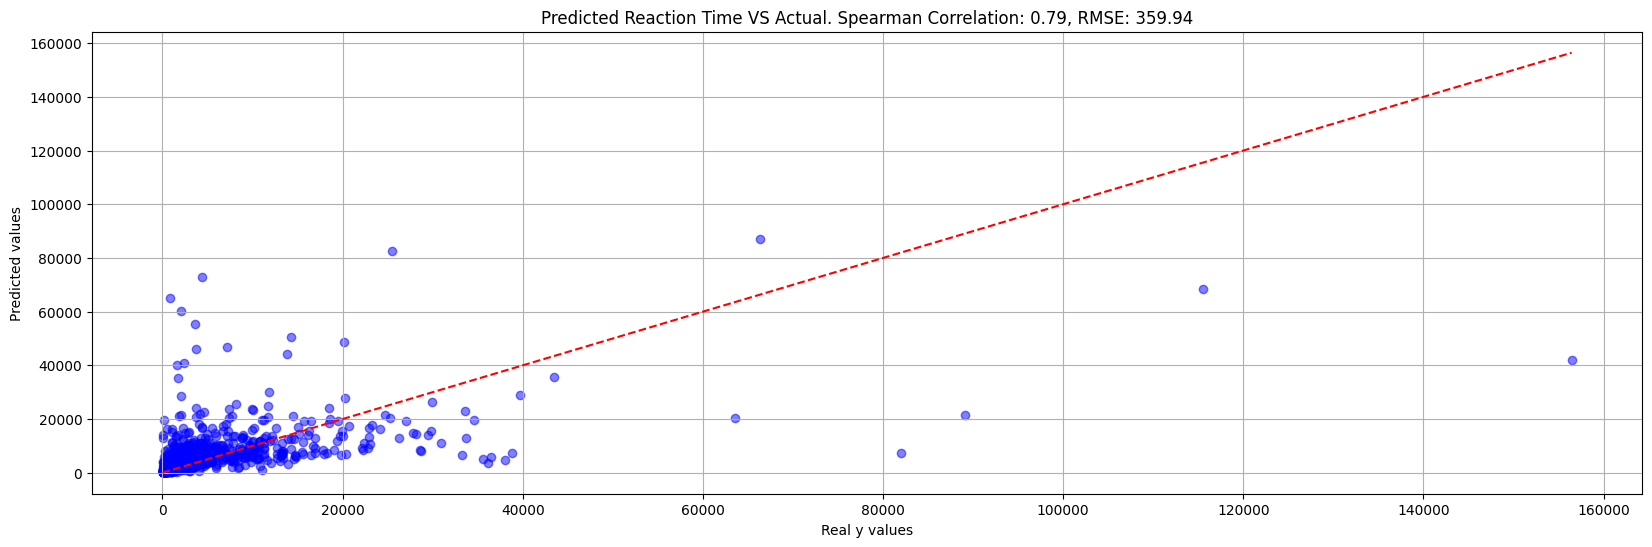

In [23]:
naive_model_rmse = np.sqrt(mean_squared_error(y_test, np.full(len(y_test), y_train.mean()), squared=False))
spearman = spearmanr(y_test, y_pred)[0]
plt.figure(figsize=(20, 6))
np.random.seed(100)
random_indices = np.random.choice(len(y_test), size=1000, replace=False)
sorted_indices = np.argsort(y_test.iloc[random_indices])
sorted_y_test = y_test.iloc[random_indices].iloc[sorted_indices]
sorted_y_pred = y_pred[random_indices][sorted_indices]

plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.5)

# Plot diagonal line
max_val = max(sorted_y_test.max(), sorted_y_pred.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

# Set plot title with RMSE
plt.title(f"Predicted Reaction Time VS Actual. Spearman Correlation: {spearman:.2f}, RMSE: {rmse:.2f}")
plt.xlabel("Real y values")
plt.ylabel("Predicted values")
plt.grid(True)
plt.show()

In [24]:
naive_model_rmse

360.14691663580936

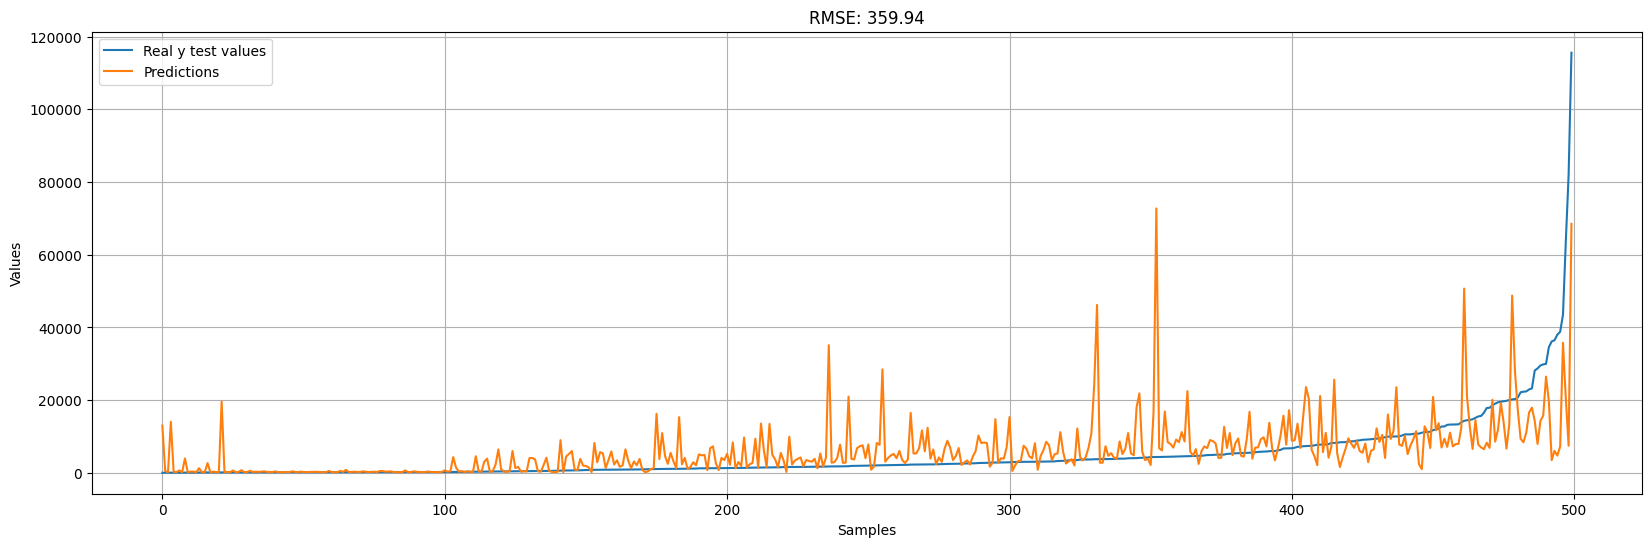

In [25]:
plt.figure(figsize=(20, 6))
np.random.seed(100)
random_indices = np.random.choice(len(y_test), size=500, replace=False)
sorted_indices = np.argsort(y_test.iloc[random_indices])
sorted_y_test = y_test.iloc[random_indices].iloc[sorted_indices]
sorted_y_pred = y_pred[random_indices][sorted_indices]
# Plot real y test values and predictions
plt.plot(sorted_y_test.reset_index(drop=True), label='Real y test values')
plt.plot(sorted_y_pred, label='Predictions')

# Set plot title with RMSE
plt.title(f"RMSE: {rmse:.2f}")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
y_test_binned = pd.cut(y_test, bins=bin_edges, labels=labels, include_lowest=True)
y_pred_binned = pd.cut(y_pred, bins=bin_edges, labels=labels, include_lowest=True)

# Calculate accuracy
accuracy = accuracy_score(y_test_binned, y_pred_binned)
print("Accuracy:", accuracy)

# Calculate F1 score (use average='weighted' to handle class imbalance)
f1 = f1_score(y_test_binned, y_pred_binned, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_binned, y_pred_binned)
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels[1:], columns=bin_labels[1:])
print("Confusion Matrix:")
display(conf_matrix_df)

Accuracy: 0.36064
F1 Score: 0.36585443200769246
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3143      550       216        119        129        112   
400-800        144      131        94         86        106        115   
800-1200        35       40        39         75        177        242   
1200-1600       18       27        26         51        163        284   
1600-2500       17       18        35         33        173        438   
2500-4000        0        5        12         16         89        384   
4000-6000        0        1         1          8         34        192   
6000-12000       0        0         2          7         23        104   
12000-20000      0        1         0          1          2         27   
20000+           0        0         1          1          5         14   

             4000-6000  6000-12000  12000-20000  20000+  
0-400              104          80           19       6  
400-800            113          83           10       5  
800-1200           155         134           24      10  
1200-1600          272         239           28      22  
1600-2500          508         495           92      46  
2500-4000          533         589           97      46  
4000-6000          385         595          122      59  
6000-12000         367         958          263     122  
12000-20000         83         322          184     104  
20000+              61         187          150     187

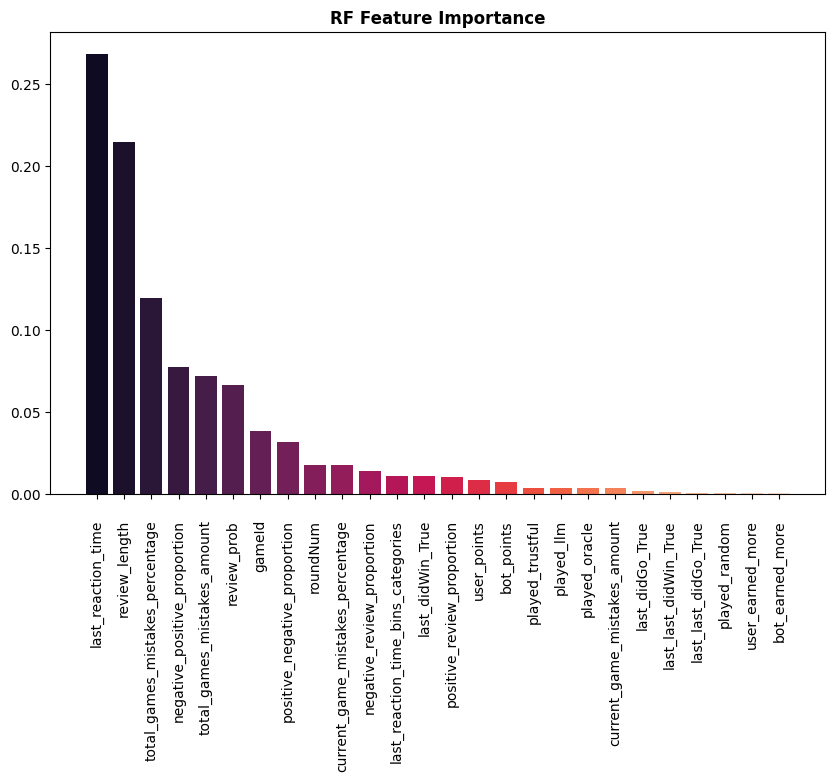

In [27]:
importances_df = pd.DataFrame({"feature_names": all_features, "importances": model.feature_importances_})
importances_df = importances_df.sort_values(by='importances', ascending=False)

importances_df = pd.DataFrame({"feature_names" : model.feature_names_in_, "importances" : model.feature_importances_}).sort_values(by='importances', ascending=False)
colors = sns.color_palette("rocket", len(model.feature_names_in_))

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(importances_df["feature_names"], importances_df["importances"], color = colors)
ax.set_xticks(range(len(importances_df["feature_names"])))
ax.set_xticklabels(importances_df["feature_names"], rotation=90, ha='center', fontsize=10)
ax.tick_params(axis='x', which='major', pad=15)
ax.set_title("RF Feature Importance", fontweight = "bold")
plt.grid(False)
plt.show()


In [28]:
selected_features = ['gameId', 'roundNum', 'user_points', 'bot_points', 'review_prob',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount', 'review_length',
                'positive_review_proportion','negative_review_proportion','positive_negative_proportion','negative_positive_proportion','user_earned_more', 'bot_earned_more',
                 'last_reaction_time', 'last_reaction_time_bins_categories', 'played_trustful']

model = RandomForestRegressor(min_samples_leaf=50, max_depth=100)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(rmse)

359.92442618853073


In [29]:
selected_features = ['gameId', 'roundNum', 'last_didGo_True', 'last_last_didGo_True', 'last_didWin_True', 'last_last_didWin_True', 'review_prob',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'review_length',
                'positive_review_proportion','negative_positive_proportion','user_earned_more', 'bot_earned_more',
                 'last_reaction_time', 'last_reaction_time_bins_categories', 'played_trustful', 'played_llm', 'played_random', 'played_oracle']

model = RandomForestRegressor(min_samples_leaf=50, max_depth=100)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(rmse)

359.9747658569588


### Classification Modeling (Binning Representation)

In [9]:
all_features_classification = [feature for feature in all_features if feature != 'last_reaction_time']
X_train, y_train =  train_df[all_features_classification], train_df[classification_label_column]
X_test, y_test = test_df[all_features_classification], test_df[classification_label_column]

In [31]:
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[all_features_classification], y_train)
y_pred = classification_model.predict(X_test[all_features_classification])

In [ ]:
train_mode = y_train.value_counts().idxmax()
naive_mode_predictions = np.full(len(y_test), train_mode)
accuracy = accuracy_score(y_test, naive_mode_predictions)
print("Accuracy:", accuracy)

f1 = f1_score(y_test, naive_mode_predictions, average='weighted')
print("F1 Score:", f1)

In [11]:
def evaluate_classification_model(model):
    num_estimators = len(model.estimators_)
    print(f"Number of estimators: {num_estimators}")
    tree_depths = [estimator.tree_.max_depth for estimator in model.estimators_]
    print(f"Depth of each tree: {tree_depths}")
    average_depth = sum(tree_depths) / num_estimators
    print(f"Average depth of trees: {average_depth}")
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels[1:], columns=bin_labels[1:])
    print("Confusion Matrix:")
    display(conf_matrix_df)

In [33]:
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [18, 18, 19, 20, 17, 19, 18, 18, 19, 19, 20, 17, 18, 18, 17, 19, 18, 18, 18, 22, 16, 19, 17, 18, 21, 20, 19, 19, 21, 19, 17, 20, 20, 21, 19, 19, 16, 18, 19, 18, 17, 18, 20, 18, 19, 19, 18, 17, 19, 16, 19, 21, 17, 18, 18, 17, 17, 18, 18, 18, 20, 18, 18, 18, 19, 19, 20, 18, 18, 17, 18, 18, 16, 18, 18, 19, 19, 18, 19, 18, 18, 16, 19, 22, 21, 17, 17, 17, 18, 17, 19, 17, 19, 19, 18, 18, 18, 18, 16, 18]
Average depth of trees: 18.36
Accuracy: 0.405056
F1 Score: 0.4093196382660061
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3685      596        97         41         27         11   
400-800        174      448       154         55         20         11   
800-1200        43      227       336        154         62         25   
1200-1600       28      167       273        269        134         71   
1600-2500       22      254       283        367        238        192   
2500-4000        8      184       231        243        171        252   
4000-6000        4      126       104        116        102        176   
6000-12000       5      125        76         96        100        142   
12000-20000      2       54        18         37         29         24   
20000+           1       69        14         25         17         13   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               12           4            2       3  
400-800             11           3            4       7  
800-1200            26          10           28      20  
1200-1600           58          50           51      29  
1600-2500          169         102          125     103  
2500-4000          296         148          132     106  
4000-6000          276         200          161     132  
6000-12000         298         374          365     265  
12000-20000         61         125          198     176  
20000+              33          59          122     253

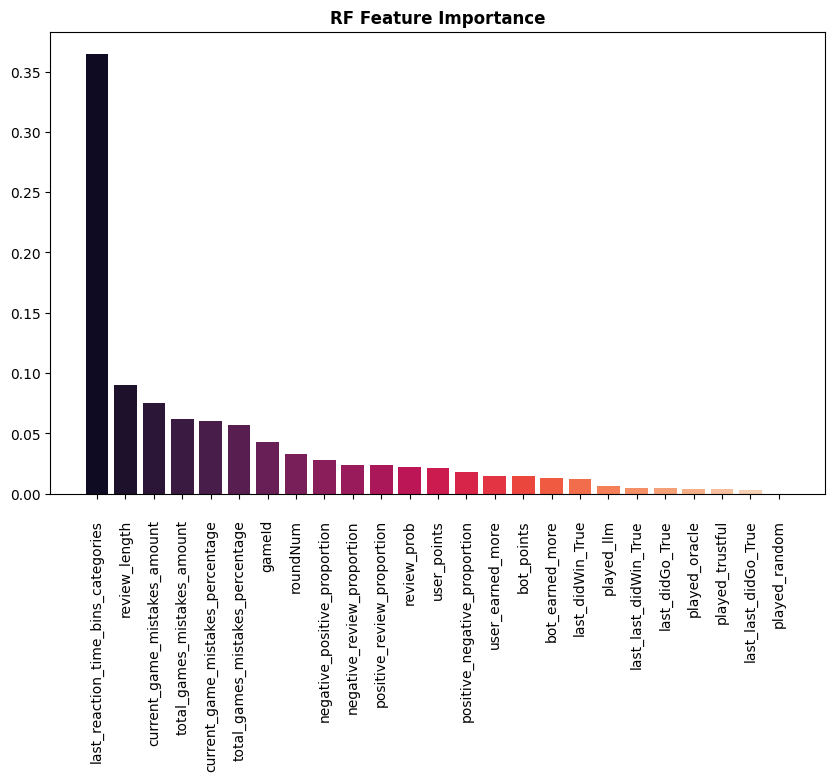

In [34]:
importances_df = pd.DataFrame({"feature_names": all_features_classification, "importances": classification_model.feature_importances_})
importances_df = importances_df.sort_values(by='importances', ascending=False)

importances_df = pd.DataFrame({"feature_names" : classification_model.feature_names_in_, "importances" : classification_model.feature_importances_}).sort_values(by='importances', ascending=False)
colors = sns.color_palette("rocket", len(classification_model.feature_names_in_))

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(importances_df["feature_names"], importances_df["importances"], color = colors)
ax.set_xticks(range(len(importances_df["feature_names"])))
ax.set_xticklabels(importances_df["feature_names"], rotation=90, ha='center', fontsize=10)
ax.tick_params(axis='x', which='major', pad=15)
ax.set_title("RF Feature Importance", fontweight = "bold")
plt.grid(False)
plt.show()


In [35]:
importances_df[:10]['feature_names'].tolist() + ['bot_earned_more']

['last_reaction_time_bins_categories',
 'review_length',
 'current_game_mistakes_amount',
 'total_games_mistakes_amount',
 'current_game_mistakes_percentage',
 'total_games_mistakes_percentage',
 'gameId',
 'roundNum',
 'negative_positive_proportion',
 'negative_review_proportion',
 'bot_earned_more']

In [36]:
chosen_features = importances_df[:10]['feature_names'].tolist() + ['bot_earned_more']
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [18, 19, 16, 17, 20, 17, 19, 19, 20, 19, 22, 17, 18, 17, 18, 20, 20, 21, 17, 18, 19, 18, 19, 17, 20, 18, 17, 18, 21, 17, 17, 18, 18, 19, 18, 19, 17, 19, 17, 18, 19, 18, 19, 18, 21, 17, 18, 17, 19, 19, 16, 19, 21, 19, 18, 19, 19, 21, 17, 20, 19, 17, 16, 18, 24, 18, 17, 17, 18, 18, 16, 18, 17, 19, 18, 16, 18, 19, 17, 18, 20, 17, 19, 21, 17, 18, 16, 20, 18, 21, 18, 18, 18, 19, 19, 18, 16, 18, 19, 18]
Average depth of trees: 18.36
Accuracy: 0.402688
F1 Score: 0.40740375336318135
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3668      595       121         41         21          8   
400-800        173      440       156         60         19         12   
800-1200        43      228       319        161         59         27   
1200-1600       27      184       260        250        124         71   
1600-2500       22      260       290        342        217        197   
2500-4000        8      190       217        232        160        254   
4000-6000        3      123       100        122         95        175   
6000-12000       5      129        68         97         93        138   
12000-20000      2       54        15         32         33         29   
20000+           1       76        10         18         17         18   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               13           4            2       5  
400-800             12           4            3       8  
800-1200            30          14           27      23  
1200-1600           63          60           53      38  
1600-2500          178         108          130     111  
2500-4000          290         161          143     116  
4000-6000          274         205          172     128  
6000-12000         290         394          375     257  
12000-20000         61         113          227     158  
20000+              25          57          135     249

In [37]:
# import pickle
# with open('models/updated_large_model_wa_strategies_6.pkl', 'wb') as f:
#     pickle.dump(classification_model, f)

In [38]:
chosen_features = importances_df[:10]['feature_names'].tolist() + ['bot_earned_more'] + ['played_trustful', 'played_llm', 'played_random', 'played_oracle']
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [18, 18, 19, 19, 18, 16, 18, 18, 16, 20, 21, 16, 18, 19, 18, 18, 18, 18, 19, 19, 18, 21, 18, 20, 22, 17, 17, 18, 20, 22, 19, 18, 20, 16, 20, 18, 23, 17, 18, 17, 17, 21, 20, 17, 18, 19, 18, 19, 19, 17, 22, 18, 23, 18, 20, 18, 21, 20, 18, 19, 20, 19, 16, 17, 19, 18, 17, 18, 19, 17, 16, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 19, 20, 20, 17, 19, 19, 17, 18, 18, 20, 18, 18, 17, 18, 22, 17, 17, 17, 18]
Average depth of trees: 18.47
Accuracy: 0.40128
F1 Score: 0.40484913771162473
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3664      597       117         44         23         12   
400-800        173      452       156         51         14         13   
800-1200        44      226       344        156         49         24   
1200-1600       27      181       280        250        113         74   
1600-2500       21      263       278        368        219        185   
2500-4000        8      195       223        230        155        233   
4000-6000        3      130       105        125         94        164   
6000-12000       5      134        77         99         98        127   
12000-20000      2       60        15         34         32         21   
20000+           1       70        12         31         12         12   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               11           4            4       2  
400-800             12           4            4       8  
800-1200            32          10           24      22  
1200-1600           59          53           52      41  
1600-2500          169         113          132     107  
2500-4000          293         169          137     128  
4000-6000          260         213          159     144  
6000-12000         281         378          375     272  
12000-20000         59         114          217     170  
20000+              27          64          124     253

In [39]:
import pickle
with open('models/updated_large_model_with_strategies_7.pkl', 'wb') as f:
    pickle.dump(classification_model, f)

In [46]:
import pickle
with open('models/rf_basic_classification_model_1.pkl', 'rb') as f:
    trained_initial_model = pickle.load(f)

In [51]:
initial_features = trained_initial_model.feature_names_in_.tolist()
initial_features

['gameId',
 'roundNum',
 'current_game_mistakes_amount',
 'current_game_mistakes_percentage',
 'total_games_mistakes_percentage',
 'review_length',
 'positive_review_proportion',
 'last_reaction_time_bins_categories',
 'user_earned_more',
 'bot_earned_more',
 'last_didGo_True',
 'last_didWin_True',
 'review_prob']

In [50]:
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[initial_features], y_train)
y_pred = classification_model.predict(X_test[initial_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [17, 19, 20, 17, 19, 18, 18, 18, 17, 23, 16, 18, 21, 18, 16, 17, 20, 17, 18, 18, 20, 18, 18, 19, 19, 20, 19, 18, 19, 18, 18, 17, 19, 21, 20, 17, 17, 16, 17, 19, 19, 19, 17, 17, 19, 20, 18, 16, 20, 19, 21, 18, 17, 19, 19, 18, 18, 20, 18, 17, 17, 20, 19, 17, 21, 17, 20, 18, 16, 17, 19, 18, 20, 18, 18, 19, 17, 18, 16, 18, 19, 20, 19, 19, 18, 19, 17, 17, 18, 18, 19, 17, 17, 17, 17, 16, 20, 19, 18, 20]
Average depth of trees: 18.3
Accuracy: 0.40192
F1 Score: 0.4063553392108302
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3667      597       127         29         24         19   
400-800        173      447       153         55         17         14   
800-1200        43      239       320        158         54         31   
1200-1600       27      180       292        243        131         60   
1600-2500       21      279       320        339        226        180   
2500-4000        8      196       248        208        173        245   
4000-6000        3      144       110        105         99        176   
6000-12000       5      144        84         74        116        121   
12000-20000      2       63        15         31         31         23   
20000+           1       73         7         21         13         15   

             4000-6000  6000-12000  12000-20000  20000+  
0-400                6           5            2       2  
400-800              8           6            4      10  
800-1200            25          16           25      20  
1200-1600           63          45           62      27  
1600-2500          157         109          121     103  
2500-4000          278         155          135     125  
4000-6000          270         199          163     128  
6000-12000         302         379          354     267  
12000-20000         58         115          215     171  
20000+              35          59          114     268

In [52]:
import pickle
with open('models/large_model_0_repeat.pkl', 'wb') as f:
    pickle.dump(classification_model, f)

In [55]:
initial_updated_features = initial_features + ['played_trustful', 'played_llm', 'played_random', 'played_oracle']
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[initial_updated_features], y_train)
y_pred = classification_model.predict(X_test[initial_updated_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [17, 16, 18, 17, 18, 17, 19, 17, 20, 18, 23, 16, 19, 19, 18, 17, 20, 19, 16, 18, 21, 16, 17, 19, 20, 17, 19, 17, 23, 18, 19, 18, 17, 22, 19, 20, 19, 16, 19, 19, 16, 17, 18, 20, 18, 17, 17, 18, 18, 18, 18, 18, 18, 16, 18, 18, 19, 18, 17, 18, 18, 18, 19, 18, 18, 19, 17, 17, 21, 17, 18, 17, 19, 17, 17, 23, 17, 17, 20, 18, 20, 20, 22, 16, 20, 17, 20, 20, 16, 23, 17, 16, 16, 17, 17, 18, 18, 17, 17, 17]
Average depth of trees: 18.21
Accuracy: 0.403072
F1 Score: 0.40688608029084533
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3670      599       112         39         22         14   
400-800        173      450       146         62         17         12   
800-1200        44      235       321        158         55         31   
1200-1600       27      170       274        264        137         60   
1600-2500       21      274       308        351        226        192   
2500-4000        8      194       219        225        184        235   
4000-6000        3      142       113        103         97        177   
6000-12000       5      136        82         81        110        130   
12000-20000      2       59        21         27         32         25   
20000+           1       72        13         23         13         11   

             4000-6000  6000-12000  12000-20000  20000+  
0-400                9           6            3       4  
400-800             10           5            3       9  
800-1200            25          14           22      26  
1200-1600           52          54           53      39  
1600-2500          158         111          116      98  
2500-4000          290         166          126     124  
4000-6000          266         203          156     137  
6000-12000         304         385          351     262  
12000-20000         58         116          214     170  
20000+              35          56          115     267

In [56]:
import pickle
with open('models/large_model_0_repeat_with_strategies_9.pkl', 'wb') as f:
    pickle.dump(classification_model, f)

### Model Investigation

In [10]:
import pickle
with open('models/updated_large_model_with_strategies_7.pkl', 'rb') as f:
    trained_model = pickle.load(f)

In [29]:
explainer = shap.TreeExplainer(trained_model.estimators_[0])
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[100], feature_names=list(trained_model.feature_names_in_))

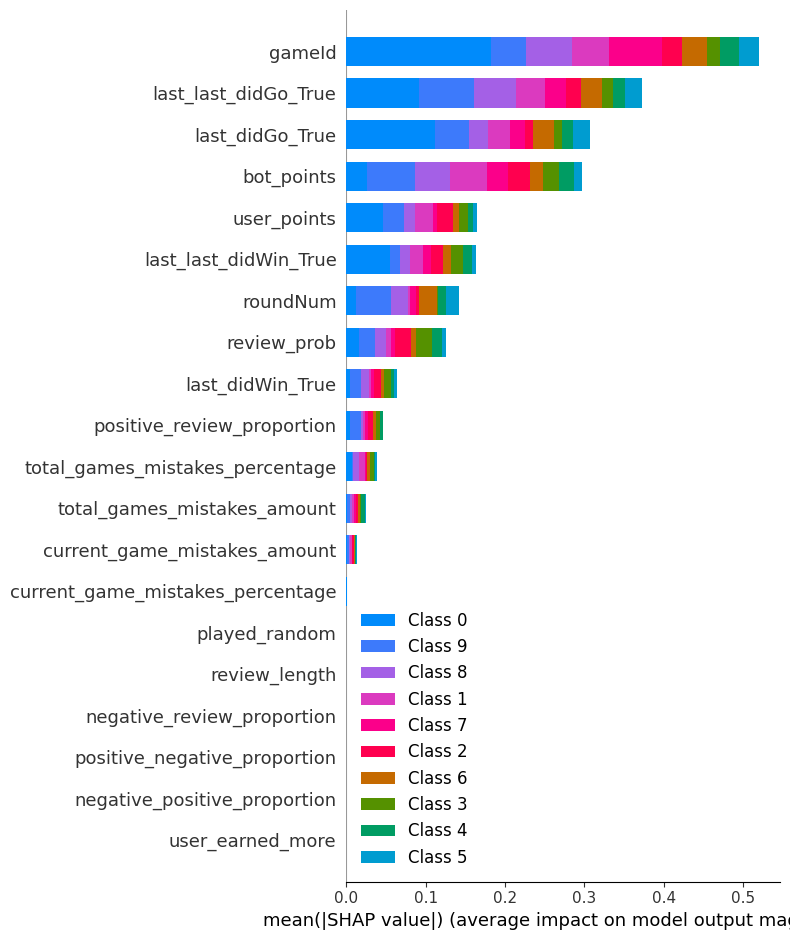

In [30]:
shap.summary_plot(shap_values, X_train)

In [35]:
for name in list(trained_model.feature_names_in_):
    shap.dependence_plot(name, shap_values, X_train)

TypeError: The passed shap_values are a list not an array! If you have a list of explanations try passing shap_values[0] instead to explain the first output class of a multi-output model.

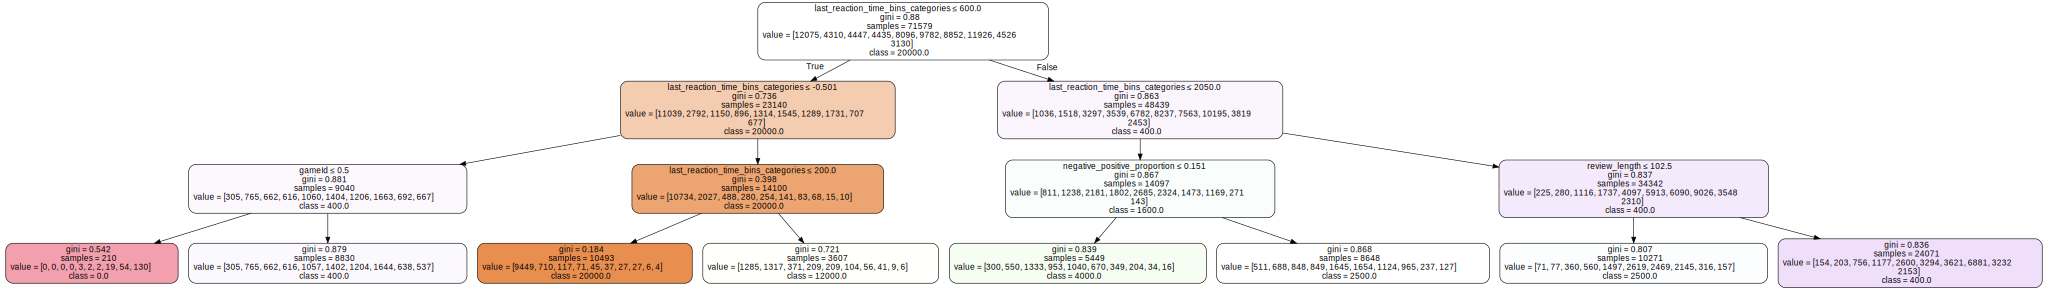

In [27]:
simple_model = DecisionTreeClassifier(max_depth=3)
simple_model.fit(X_train[list(trained_model.feature_names_in_)], y_train)
dot_data = export_graphviz(
    simple_model,
    out_file=None,
    feature_names=list(trained_model.feature_names_in_),
    class_names=[str(c) for c in y_train.unique()],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph

In [40]:
import lime
features = list(trained_model.feature_names_in_)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train[features].values, 
    feature_names=features,
    class_names=y_train.unique().tolist(), 
    discretize_continuous=True
)

# Explain the first instance in the training set
exp = explainer_lime.explain_instance(X_train[features].iloc[100].values, trained_model.estimators_[0].predict_proba, num_features=4)
exp.show_in_notebook(show_table=True)

In [41]:
import lime
features = list(trained_model.feature_names_in_)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train[features].values, 
    feature_names=features,
    class_names=y_train.unique().tolist(), 
    discretize_continuous=True
)

# Explain the first instance in the training set
exp = explainer_lime.explain_instance(X_train[features].iloc[100].values, trained_model.predict_proba, num_features=4)
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
